In [0]:
#train.csv - id, tweet_text, labels one hot encoded
#test.csv - id, tweet_text
#test_labels.csv - id, labels one hot encoded -- of test texts

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive/My Drive/IronyDetection/Classification_system/

/content/drive/My Drive/IronyDetection/Classification_system


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers, Model
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, SpatialDropout1D, LSTM, Bidirectional, TimeDistributed, Input
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

sns.set_style("whitegrid")
#np.random.seed(0)

#DATA_PATH = ''
#EMBEDDING_DIR = ''

MAX_NB_WORDS = 200000
tokenizer = RegexpTokenizer(r'\w+')
#stop_words = set(stopwords.words('english'))
#stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Let's load the data and the embeddings...

In [0]:
#load embeddings
#print('loading word embeddings...')
#embeddings_index = {}
#f = codecs.open('../input/fasttext/wiki.simple.vec', encoding='utf-8')
#for line in tqdm(f):
#    values = line.rstrip().rsplit(' ')
#    word = values[0]
#    coefs = np.asarray(values[1:], dtype='float32')
#    embeddings_index[word] = coefs
#f.close()
#print('found %s word vectors' % len(embeddings_index))

In [0]:
from gensim.models import FastText
embeddings_index = FastText.load("hinglish_fasttext_stopwords_present_rarewords_absent.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from gensim.models import Word2Vec
embeddings_index = Word2Vec.load("hinglish_plus_english_word2vec_stopwords_present_rarewords_absent.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


num train:  106899
num test:  251
23


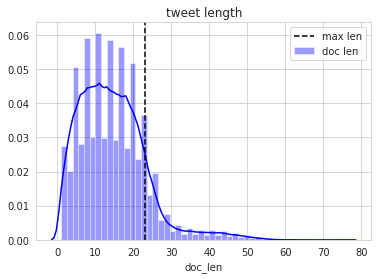

In [0]:
#load data

train_df = pd.read_csv('../Dataset/total_tweets_tags_removed_shuffled.csv', sep=',', header=0, encoding='ISO-8859-1')
test_df = pd.read_csv('../Dataset/test_tweet_data.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])
#print(test_df)
#label_names = ["sarcastic", "not_sarcastic"]
label_names = ["sarcastic"]

y_train = train_df[label_names].values
y_test = test_df[label_names].values
#y_train=y_train[0:4999]
#y_test=y_train[:251]
#print(len(y_train))
#print(len(y_test))
#visualize word distribution
train_df['doc_len'] = train_df['tweet_text'].astype(str).apply(lambda words: len(words.split(" ")))
#test_df['doc_len'] = test_df['tweet_text'].astype(str).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
#max_seq_len = train_df['doc_len'].max()
print(max_seq_len)
sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); 
plt.legend()
plt.show()

Let's pre-process the text, tokenize it and pad it to a maximum length (as in the figure above).

In [0]:
processed_docs_train = train_df['tweet_text'].astype(str).tolist()
processed_docs_test = test_df['tweet_text'].astype(str).tolist() 
num_classes = len(label_names)

#raw_docs_train = train_df['tweet_text'].tolist()
#raw_docs_test = test_df['tweet_text'].tolist() 

#print(processed_docs_train)

#print("pre-processing train data...")
#processed_docs_train = []
#for doc in tqdm(raw_docs_train):
#    tokens = tokenizer.tokenize(str(doc))
#    filtered = [word for word in tokens if word not in stop_words]
#    filtered = [word for word in tokens]
#    processed_docs_train.append(" ".join(filtered))

#print(processed_docs_train)
#end for

#processed_docs_test = []
#for doc in tqdm(raw_docs_test):
#    tokens = tokenizer.tokenize(doc)
#    #filtered = [word for word in tokens if word not in stop_words]
#    filtered = [word for word in tokens]
#    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
total_docs=[]
total_docs.extend(processed_docs_train)
total_docs.extend(processed_docs_test)
#tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
tokenizer.fit_on_texts(total_docs)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
#print(word_seq_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print(len(word_index))
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
print(word_seq_train[2])
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

tokenizing input data...
9842
dictionary size:  9842
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   91  437   89   15   27  407 1249  295]


We can now prepare our embedding matrix limiting to a max number of words:

In [0]:
#training params
batch_size = 64
num_epochs = 8 

#model parameters
num_filters = 128 
num_kernels=200
stride=1
embed_dim = 300
weight_decay = 1e-4

#parallel layers 
kernel_size=7
kernel_size_p1=3
kernel_size_p2=6
kernel_size_p3=9
kernel_size_p4=12

In [0]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.random.rand(nb_words, embed_dim)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    #print(word)

    if embeddings_index.wv.__contains__(word): 

        embedding_vector = embeddings_index.wv[word]
    
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
#print(embedding_matrix)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 0


In [0]:
print(len(embedding_matrix[34]))

300


In [0]:
print(words_not_found)
#print(embeddings_index.wv.__contains__("abe"))
#print(embeddings_index.wv['ddlj'])
#print(len(words_not_found))
#print(len(embedding_matrix))
#print(len(word_index))


['2f', 'j6']


It's interesting to look at the words not found in the embeddings:

In [0]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['j6' '2f' '2f' 'j6' 'j6' 'j6' '2f' 'j6' '2f' 'j6']


Let's define our training and model parameters:

We can finally define the CNN architecture

In [0]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_kernels, kernel_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_kernels, kernel_size, activation='relu', padding='same'))
#model.add(GlobalMaxPooling1D())
model.add(MaxPooling1D(2))
#model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)
model.add(Dense(1, activation='sigmoid')) 

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 300)           2952600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 200)           420200    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 200)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 200)           280200    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 200)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2

In [0]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=20, validation_split=0.1, shuffle=True)

Train on 96209 samples, validate on 10690 samples
Epoch 1/20
96209/96209 [==============================] - 179s 2ms/step - loss: 0.6132 - accuracy: 0.6581 - val_loss: 0.5822 - val_accuracy: 0.6952
Epoch 2/20
96209/96209 [==============================] - 178s 2ms/step - loss: 0.5677 - accuracy: 0.6981 - val_loss: 0.5537 - val_accuracy: 0.7088
Epoch 3/20
96209/96209 [==============================] - 179s 2ms/step - loss: 0.5418 - accuracy: 0.7158 - val_loss: 0.5352 - val_accuracy: 0.7218
Epoch 4/20
96209/96209 [==============================] - 181s 2ms/step - loss: 0.5207 - accuracy: 0.7311 - val_loss: 0.5383 - val_accuracy: 0.7139
Epoch 5/20
96209/96209 [==============================] - 176s 2ms/step - loss: 0.4996 - accuracy: 0.7448 - val_loss: 0.5313 - val_accuracy: 0.7222
Epoch 6/20
96209/96209 [==============================] - 176s 2ms/step - loss: 0.4770 - accuracy: 0.7611 - val_loss: 0.5329 - val_accuracy: 0.7225
Epoch 7/20
96209/96209 [==============================] - 180s

KeyboardInterrupt: ignored

In [0]:
print("training CNN2 ...")

inputt = Input(shape=(max_seq_len,))
model = Embedding(nb_words, embed_dim,weights=[embedding_matrix],input_length=max_seq_len, trainable = False)(inputt)
tower_1 = Conv1D(num_kernels, kernel_size_p1, padding='same', activation='relu', strides=stride)(model)
tower_2 = Conv1D(num_kernels, kernel_size_p2, padding='same', activation='relu', strides=stride)(model)
tower_3 = Conv1D(num_kernels, kernel_size_p3, padding='same', activation='relu', strides=stride)(model)
tower_4 = Conv1D(num_kernels, kernel_size_p4, padding='same', activation='relu', strides=stride)(model)
model = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis=1)
model = GlobalMaxPooling1D()(model)
model = Dropout(0.5)(model)
#model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dense(64, activation='relu')(model)
output = Dense(num_classes, activation='sigmoid')(model)
model = Model(inputt, output)

#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


In [0]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=20, validation_split=0.1, shuffle=True)

In [0]:
#LSTM Params

lstm_out1 = 150
bilstm_out1 = 96
lstm_out2 = 32
dropout = 0.2
recurrent_dropout = 0.2

In [0]:
#LSTM

model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(LSTM(lstm_out1, dropout_U = 0.2, dropout_W = 0.2))
#model.add(MaxPooling1D(2))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

In [0]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=20, validation_split=0.1, shuffle=True)

In [0]:
# BiLSTM

# main model
inputt = Input(shape=(max_seq_len,))
model = Embedding(nb_words, embed_dim,weights=[embedding_matrix],input_length=max_seq_len, trainable = False)(inputt)
model =  Bidirectional (LSTM (lstm_out1, return_sequences=True, dropout_U = 0.2, dropout_W = 0.2 ), merge_mode='concat')(model)
model = TimeDistributed(Dense(10,activation='relu'))(model)
model = Flatten()(model)
model = Dense(64,activation='relu')(model)
output = Dense(1,activation='sigmoid')(model)
model = Model(inputt,output)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

In [0]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=20, validation_split=0.1, shuffle=True)

In [0]:
# Attention BiLSTM

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight( shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        #print(self.name)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [0]:
inp = Input(shape=(max_seq_len, ))
x = Embedding(nb_words, embed_dim, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(LSTM(lstm_out1, return_sequences=True, dropout=0.20, recurrent_dropout=0.20))(x)
x = Attention(max_seq_len)(x)
x = Dense(64, activation="relu")(x)
#x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

In [0]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=20, validation_split=0.1, shuffle=True)

In [0]:
inp = Input(shape=(max_seq_len, ))
x = Embedding(nb_words, embed_dim, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.25, recurrent_dropout=0.25))(x)
x = Attention(max_seq_len)(x)
x = Dense(256, activation="relu")(x)
#x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 23, 300)           2952600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 23, 600)           1442400   
_________________________________________________________________
attention_1 (Attention)      (None, 600)               623       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               153856    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 4,549,736
Trainable params: 1,597,136
Non-trainable params: 2,952,600
_________________________________________

In [0]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True)

Train on 96209 samples, validate on 10690 samples
Epoch 1/8
96209/96209 [==============================] - 136s 1ms/step - loss: 0.5580 - accuracy: 0.7032 - val_loss: 0.5089 - val_accuracy: 0.7437
Epoch 2/8
96209/96209 [==============================] - 133s 1ms/step - loss: 0.4989 - accuracy: 0.7474 - val_loss: 0.4786 - val_accuracy: 0.7637
Epoch 3/8
96209/96209 [==============================] - 131s 1ms/step - loss: 0.4653 - accuracy: 0.7692 - val_loss: 0.4775 - val_accuracy: 0.7597
Epoch 4/8
96209/96209 [==============================] - 131s 1ms/step - loss: 0.4374 - accuracy: 0.7876 - val_loss: 0.4554 - val_accuracy: 0.7767
Epoch 5/8
96209/96209 [==============================] - 134s 1ms/step - loss: 0.4091 - accuracy: 0.8048 - val_loss: 0.4626 - val_accuracy: 0.7797
Epoch 6/8
96209/96209 [==============================] - 132s 1ms/step - loss: 0.3849 - accuracy: 0.8188 - val_loss: 0.4648 - val_accuracy: 0.7737
Epoch 7/8
96209/96209 [==============================] - 132s 1ms/st

In [0]:
print(y_train)
print(len(y_train))

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
4999


In [0]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True)

NameError: ignored

Because of the multi-label loss, we are using k-hot encoding of the output and sigmoid activations. As a result, the loss is binary cross-entropy.

In [0]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

Let's make predictions on the test data:

In [0]:
y_pred = model.predict(word_seq_test)
print(y_pred)
from sklearn.metrics import classification_report

#y_pred = model.predict(word_seq_test, batch_size=64, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1)
#y_final=y_pred_bool.round
print(classification_report(y_test, y_pred.round()))

[[0.74227786]
 [0.5047133 ]
 [0.8221329 ]
 [0.4604183 ]
 [0.91411513]
 [0.52935994]
 [0.9285195 ]
 [0.699492  ]
 [0.50055104]
 [0.77881575]
 [0.45935008]
 [0.99589455]
 [0.714272  ]
 [0.99890804]
 [0.95115834]
 [0.8540589 ]
 [0.73217684]
 [0.5370274 ]
 [0.6116317 ]
 [0.9704306 ]
 [0.85503036]
 [0.83672565]
 [0.95010334]
 [0.56763524]
 [0.9049514 ]
 [0.595439  ]
 [0.4202568 ]
 [0.96245635]
 [0.9527545 ]
 [0.92329115]
 [0.6713236 ]
 [0.9456618 ]
 [0.9726731 ]
 [0.9448101 ]
 [0.92816687]
 [0.9555551 ]
 [0.8508468 ]
 [0.8108252 ]
 [0.966388  ]
 [0.72358817]
 [0.870922  ]
 [0.8803662 ]
 [0.916993  ]
 [0.4897167 ]
 [0.6230776 ]
 [0.9450136 ]
 [0.54772323]
 [0.4123038 ]
 [0.897395  ]
 [0.7520355 ]
 [0.73475075]
 [0.5940251 ]
 [0.78745985]
 [0.95681524]
 [0.9990702 ]
 [0.45634347]
 [0.66067195]
 [0.8372949 ]
 [0.9591135 ]
 [0.7314591 ]
 [0.766696  ]
 [0.5349784 ]
 [0.8003424 ]
 [0.97009665]
 [0.99233997]
 [0.8244031 ]
 [0.87771237]
 [0.9276703 ]
 [0.7717381 ]
 [0.9410118 ]
 [0.47282058]
 [0.97

In [0]:
#create a submission
submission_df = pd.DataFrame(columns=['tweet_id'] + label_names)
submission_df['tweet_id'] = test_df['tweet_id'].values 
submission_df[label_names] = y_test 
submission_df.to_csv("./cnn_fasttext_submission.csv", index=False)

Looking at training and validation loss / accuracy figures below, we can see there is no sign of over-fitting.

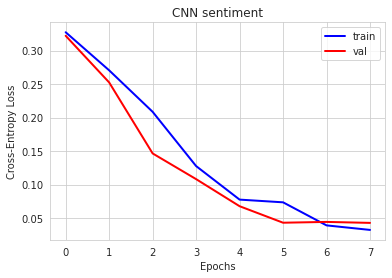

In [0]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

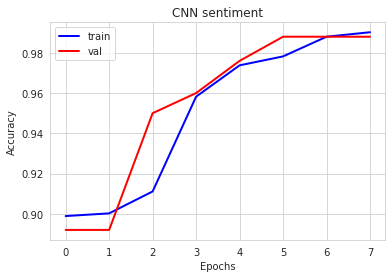

In [0]:
plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

**References:**

[1] P. Bojanowski, E. Grave, A. Joulin, T. Mikolov, "Enriching Word Vectors with Subword Information", arXiv, 2016  
[2] FastText Embeddings: https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md  
[3] F. Chollet, "Deep Learning with Python", Manning Publications, 2017  